In [61]:
#Importing libarries and tools we are gonna need:
import pydotplus
from IPython.display import display, Image
import pydotplus
from IPython.display import Image, display
import googletrans  
from gtts import gTTS
import IPython.display as ipd
import graphviz
from PIL import Image
import os
from tqdm import tqdm
from pickle import load
from PIL import Image
import numpy as np 
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud
from translate import Translator
import random
import time
import shutil
import pathlib
import itertools


import nltk
nltk.download('stopwords')
nltk.download('punkt')
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textwrap import wrap
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tensorflow.keras.utils import Sequence
from collections import defaultdict

from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# The BatchNormalization layer in Keras applies batch normalization to the input.
from tensorflow.keras.layers import Bidirectional, LSTM,BatchNormalization,Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras import Input, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, save_model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import add
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Read the data and visualize some samples and info**

In [2]:
BASE_DIR = "flickr30k_images"
WORKING_DIR = "Image capturing tr2"

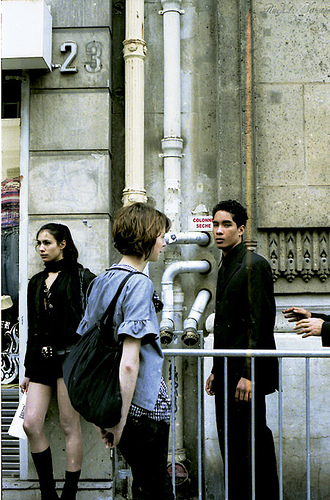

In [3]:
from IPython.display import Image
Image(BASE_DIR+'/'+'1001465944.jpg')

In [4]:
data = pd.read_csv("captions_30k.txt",sep='|')
data

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [5]:
#Prepare the data for visualisations
grouped_data = data.groupby('image_name')[' comment'].apply(lambda group: group.values.tolist()).reset_index(name='comments')

In [6]:
img_path= [BASE_DIR+'/'+image_name for image_name in grouped_data['image_name']]
descriptions= grouped_data['comments']

In [7]:
def visualize_samples(image_paths, descriptions, num_samples=7):

    sampled_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))
    sampled_image_paths = [image_paths[i] for i in sampled_indices]
    sampled_descriptions = [descriptions[i] for i in sampled_indices]

    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 20))

    for i in range(num_samples):
        img_path = sampled_image_paths[i]
        description_list = [desc.split(' ', 1)[1] for desc in sampled_descriptions[i]]

        # Load and display image
        img = mpimg.imread(img_path)
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')

        # Display multiple descriptions as text
        axs[i, 1].text(0.5, 0.5, '\n'.join(description_list), fontsize=10, va='center', ha='center', wrap=True)
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

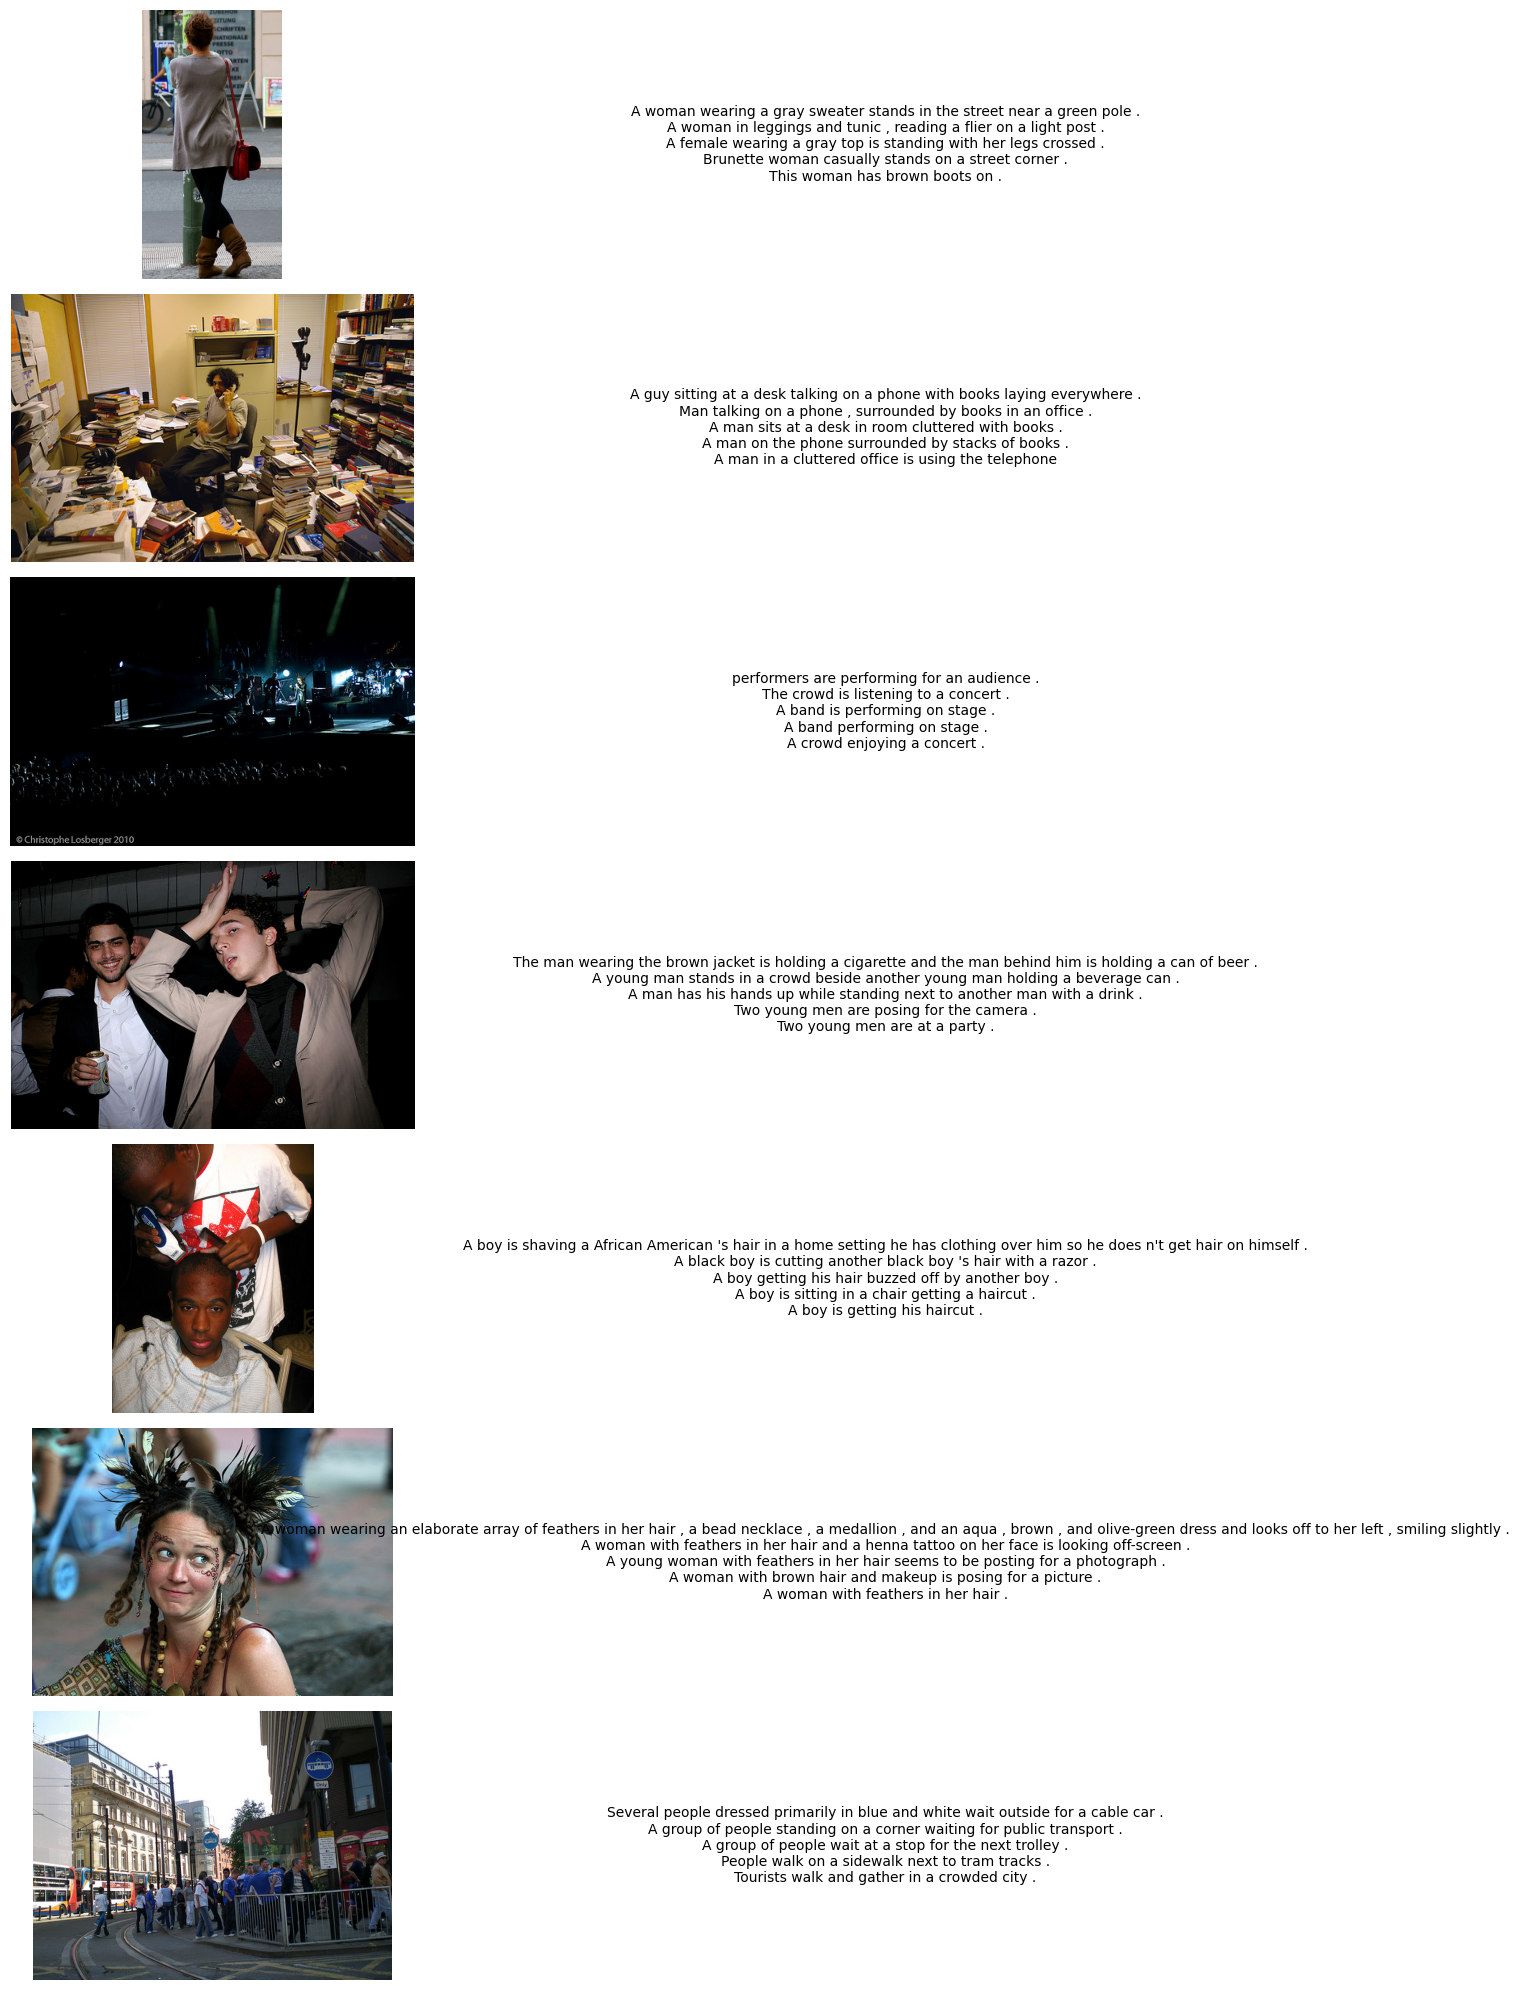

In [8]:
visualize_samples(img_path, descriptions)

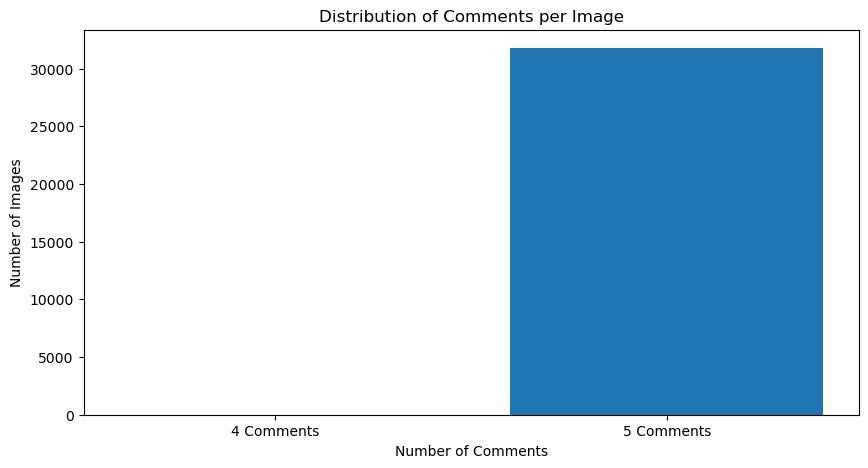

In [9]:
#Visualize the distribution of comments per image to understand how many comments are typically associated with each image.

comments_per_image = data.groupby('image_name')[' comment'].count()

images_with_4_comments = comments_per_image[comments_per_image == 4]
images_with_5_comments = comments_per_image[comments_per_image == 5]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar([3.5, 4.5], [len(images_with_4_comments), len(images_with_5_comments)], tick_label=['4 Comments', '5 Comments'])
plt.xlabel('Number of Comments')
plt.ylabel('Number of Images')
plt.title('Distribution of Comments per Image')
plt.show()

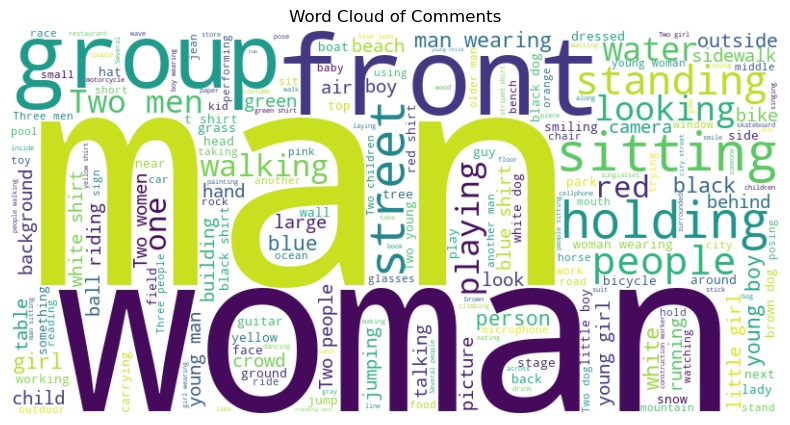

In [10]:
#Generate a word cloud to visualize the most frequent words in the comments

all_comments_text = ' '.join(data[' comment'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


In [11]:
data.isna().sum()

image_name         0
 comment_number    0
 comment           1
dtype: int64

In [12]:
images_with_4_comments

image_name
2199200615.jpg    4
Name:  comment, dtype: int64

In [13]:
image_to_delete = '2199200615.jpg'
file_name_column = 'image_name'


index_to_delete = data[data[file_name_column] == image_to_delete].index
index_to_delete

Int64Index([19995, 19996, 19997, 19998, 19999], dtype='int64')

In [14]:
data = data.drop(index_to_delete, axis=0)
data.reset_index(drop=True, inplace=True)

In [15]:
data.isna().sum()

image_name         0
 comment_number    0
 comment           0
dtype: int64

In [16]:
#We are not gonna use this column as it doesnot add any information for us or the model
data.drop([' comment_number'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [17]:
data

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
158905,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...
158906,998845445.jpg,"A young man hanging over the side of a boat ,..."
158907,998845445.jpg,A man is leaning off of the side of a blue an...
158908,998845445.jpg,"A man riding a small boat in a harbor , with ..."


**Now we Load the model and start preprocessing the images**

In [18]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

In [19]:
model = VGG16()
model.summary()
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Now we are going to use the pre-trained model called vgg16 which is already trained with large datasets to extract the features from these models. vgg16 was trained on an imagenet dataset with 1000 different classes to classify the images. We can use keras.applications to import this model directly. We need to do a few changes to the vgg16 model to integrate it with our model. The vgg16 model takes 224*224*3 image size as input so we need to delete the last classification layer and extract out the feature vectors.**

In [20]:
features = {}
directory = os.path.join(BASE_DIR+'/')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

100%|█████████████████████████████████████████████████████████████████████████| 31783/31783 [25:36:20<00:00,  2.90s/it]


In [20]:
features_save_path = "Images_features.pkl"

In [24]:
import pickle
with open(features_save_path, "wb") as feature_file:
    pickle.dump(features, feature_file)


In [21]:
import pickle

with open(features_save_path, "rb") as feature_file:
    features = pickle.load(feature_file)

**Read and preprocessing the Text data**

In [22]:
with open(os.path.join( "captions.txt"), 'r') as f:
    next(f)
    captions_doc = f.read()

In [23]:
mapping = {}
# process lines
for line in captions_doc.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [24]:
mapping['998845445']

['0 A man in shorts and a Hawaiian shirt leans over the rail of a pilot boat  with fog and mountains in the background .',
 '1 A young man hanging over the side of a boat  which is in a like with fog rolling over a hill behind it .',
 '2 A man is leaning off of the side of a blue and white boat as it sits in a body of water .',
 '3 A man riding a small boat in a harbor  with fog and mountains in the background .',
 '4 A man on a moored blue and white boat with hills and mist in the background .']

In [25]:
len(mapping)

31783

In [26]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [27]:
# preprocess the text
clean(mapping)

In [28]:
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [29]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

158915

In [30]:
#Tokenize The text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

18320

In [31]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

**Train test split the data**

In [32]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.95)
train = image_ids[:split]
test = image_ids[split:]
print(len (test))
print(len (train))

1590
30193


**For training the model as a supervised learning task we need to feed it with input and output sequences. Total 8k images with long feature vector and the caption represented as numbers are present in our training sets. It’s not possible to hold such a large amount of data into memory so we are going to use a generator method that will yield batches.**

In [33]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [35]:
# gc is the garbage collector module in Python. 
# It provides functions to manage the memory allocation and deallocation in your program
import gc

# Image feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(fe1)  #regularize using l2 to avoid overfitting

# Partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

# Decoder
decoder = Concatenate()([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(decoder) 
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge the two networks
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [36]:

learning_rate = 0.001
#clipvalue: is a technique used to limit the magnitude of gradients during trainin
#This prevents the gradients from growing too large, which can lead to unstable training behavior, such as exploding gradients.
optimizer = Adam(learning_rate=learning_rate,clipvalue=5.0)

model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [36]:
checkpoint_filepath = 'model_gen_checkpoint.h5'

In [ ]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

# Define a ModelCheckpoint callback
#Callbacks provide flexibility and customization to the training process,

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    
)
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])

  8/943 [..............................] - ETA: 2:38:12 - loss: 3.3192

In [40]:
model = load_model('model_gen_checkpoint.h5')

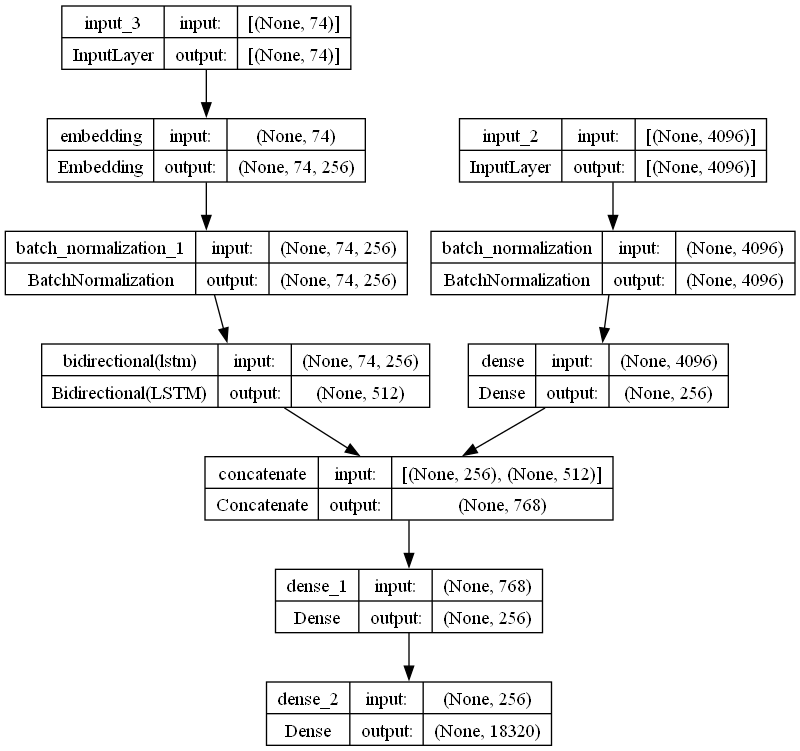

In [41]:

plot_model(model, show_shapes=True)

In [42]:
def idx_to_word(integer, tokenizer):
    for word,index, in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [43]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

**BLEU (Bilingual Evaluation Understudy) score is a metric commonly used to evaluate the quality of machine-generated text, particularly in the context of machine translation tasks. It was proposed as a way to assess the quality of translated text by comparing it to one or more reference translations.**

In [44]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████████████████████████████████████████████████████████████████████████| 1590/1590 [15:12<00:00,  1.74it/s]


BLEU-1: 0.522517
BLEU-2: 0.274577


**Now Lets Test Our Model** 

In [70]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("C:/Users/User/Final Project/Image capturing tr2/flickr30k_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    translator = Translator(to_lang="ar")
    
    
    # Remove 'startseq' and 'endseq' tokens
    y_pred = ' '.join(y_pred.split()[1:-1])
    translated_text = translator.translate(y_pred)
    
    tts = gTTS(translated_text, lang='ar')
    tts.save('test.mp3')
    

    print('--------------------Predicted--------------------')
    print(y_pred)
    print('--------------------Translated--------------------')
    print(translated_text)
    
    plt.imshow(image)


In [46]:
test[:1]

['74137268']

---------------------Actual---------------------
startseq two men wave to the camera during winter snowfall and one is seated on small riding lawn mower rigged to remove snow endseq
startseq two men are hard at work in what appears to be snow removal endseq
startseq two men pausing for photo while clearing snow endseq
startseq the men are waving as they are standing in snow endseq
startseq two guys in the snow waving at the camera endseq
--------------------Predicted--------------------
man in blue shirt is riding his bike in the snow
--------------------Translated--------------------
رجل يرتدي قميصًا أزرق يركب دراجته في الثلج


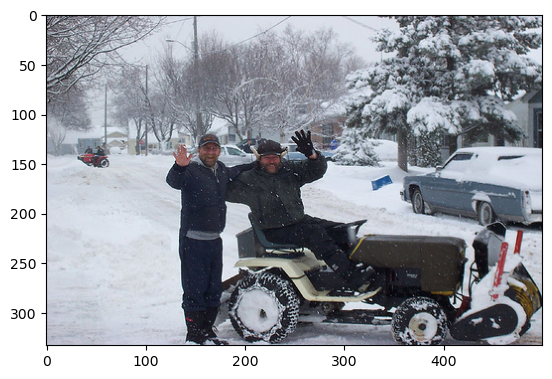

In [71]:
from PIL import Image

generate_caption('74137268.jpg')
audio_path="test.mp3"
ipd.Audio(audio_path, autoplay=True)

In [52]:
test[:10]

['74137268',
 '7414768750',
 '7416738744',
 '7417714642',
 '742073622',
 '7420874336',
 '7420985602',
 '7421074812',
 '74213476',
 '7421349720']

---------------------Actual---------------------
startseq little child stands in the middle of the street wearing large red hat while people sit on the grass endseq
startseq boy wearing red hat is standing in the middle of the road endseq
startseq small child with funny red hat stands in the road endseq
startseq small boy wearing red hat is standing in street endseq
startseq boy stands in the road wearing big red hat endseq
--------------------Predicted--------------------
young boy in blue shirt is running in race
--------------------Translated--------------------
الولد الصغير ذو القميص الأزرق يركض في السباق


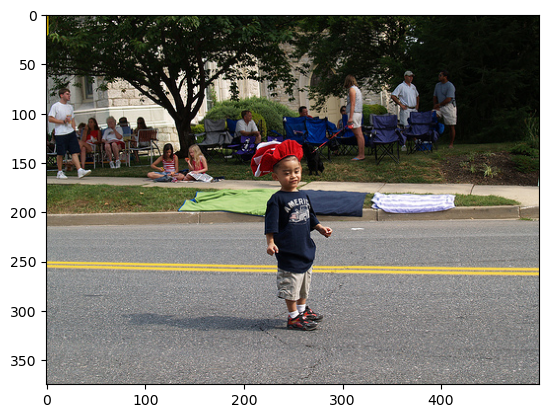

In [72]:
generate_caption('742073622.jpg')

In [58]:
model.save('Final_caption_gen_model.h5')

**لازال الموديل يحتوي على بعض الاخطاء كما هو ظاهر لكن كنتيجة اولية اعتقد انها جيدة **